In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def load_and_prepare(filename:str, columns:list[str]=["value", "kubernetes_pod_name", "topic"]) -> pd.DataFrame:
    """Loads a parquet file and ensures timestamp is index."""
    if not os.path.exists(filename):
        print(f"File {filename} not found.")
        raise Exception("File not Found")
    df = pd.read_parquet(filename)
    df = df[columns]

    df.index = df.index.to_series() - pd.Timedelta(hours=3)

    df = df[df.index > pd.Timestamp('2025-12-26 14:15:00')]
    df = df[df.index < pd.Timestamp('2025-12-26 16:25:00')]

    #Usually index is the timestamp from Prometheus
    return df.sort_index()

def calculate_rate(df: pd.DataFrame, value_col='value', columns:list[str]=["kubernetes_pod_name", "topic"]) -> pd.Series:
    """Calculates the rate per second for counter metrics."""
    # Group by labels (topic, instance, etc.) to calculate rates correctly
    group_cols = columns
    
    def get_rate(group):
        # Rate = (val_t2 - val_t1) / (time_t2 - time_t1 in seconds)
        delta_val = group[value_col].diff()
        delta_time = group.index.to_series().diff().dt.total_seconds()
        # If delta_val is negative, the prometheus counter reset. 
        # We treat the new value as the actual increase for that interval
        rate = delta_val / delta_time
        rate.loc[delta_val < 0] = group.loc[delta_val < 0, value_col] / delta_time.loc[delta_val < 0]
        return rate

    return df.groupby(group_cols, group_keys=False).apply(get_rate)

# EDGE

In [2]:
data_folder = "../../data/raw/experiment08/experiment08_edge"

# List of files to analyze
files = {
    'messages': f'{data_folder}/kafka_server_brokertopicmetrics_messagesin_total.parquet',
    'bytes_in': f'{data_folder}/kafka_server_brokertopicmetrics_bytesin_total.parquet',
    'bytes_out': f'{data_folder}/kafka_server_brokertopicmetrics_bytesout_total.parquet',
    'lag': f'{data_folder}/kafka_server_replicafetchermanager_maxlag.parquet',
    'offsets': f'{data_folder}/kafka_topic_partition_current_offset.parquet',
    'io_ratio': f'{data_folder}/kafka_server_socket_server_metrics_io_ratio.parquet',
    'io_time': f'{data_folder}/kafka_server_socket_server_metrics_iotime.parquet'
}

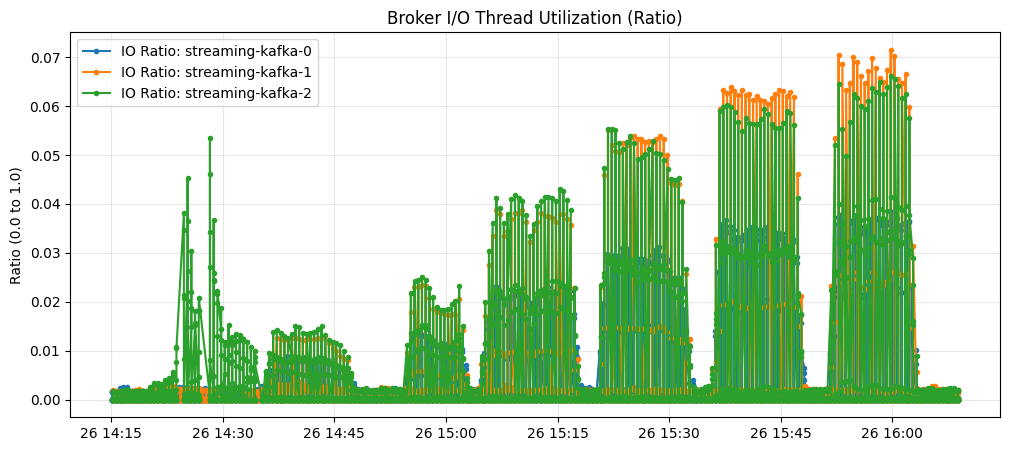

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Analyze IO Ratio (Busy-ness)
df_ratio = load_and_prepare(files['io_ratio'], columns=["kubernetes_pod_name", "value"])

plt.figure(figsize=(12, 5))
for pod, data in df_ratio.groupby('kubernetes_pod_name'):
    plt.plot(data.index, data['value'], label=f"IO Ratio: {pod}", marker='.')

plt.title("Broker I/O Thread Utilization (Ratio)")
plt.ylabel("Ratio (0.0 to 1.0)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('io_ratio_analysis.png')

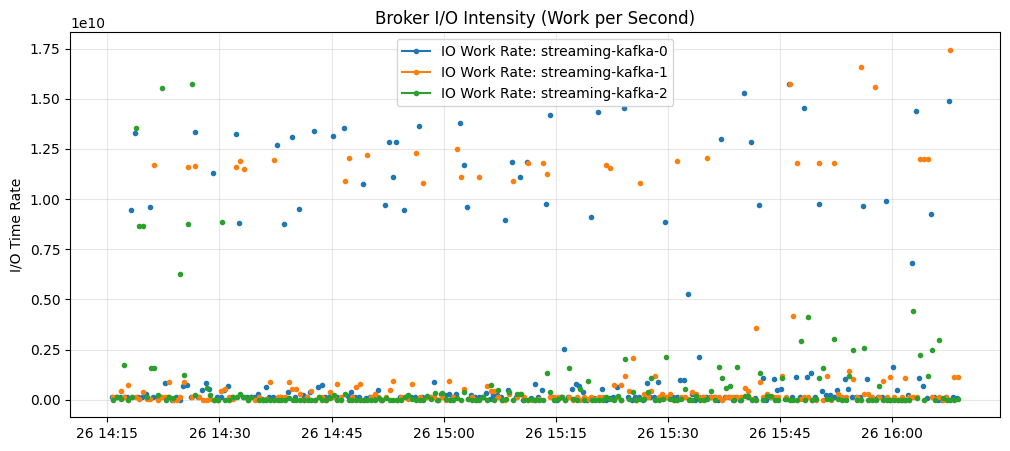

In [4]:
# 2. Analyze IO Time Rate
# IOTime is likely a counter, so we calculate the rate of change
df_iotime = load_and_prepare(files['io_time'], columns=["kubernetes_pod_name", "value"])

def calculate_io_rate(group):
    delta_val = group['value'].diff()
    delta_time = group.index.to_series().diff().dt.total_seconds()
    # Handle resets (negative delta)
    rate = delta_val / delta_time
    rate[delta_val < 0] = group['value'] / delta_time
    return rate

plt.figure(figsize=(12, 5))
for pod, data in df_iotime.groupby('kubernetes_pod_name'):
    # Ensure data is sorted for rate calculation
    data = data.sort_index()
    io_rate = calculate_io_rate(data)
    plt.plot(data.index, io_rate, label=f"IO Work Rate: {pod}", marker='.')

# plt.axvline(target_time_local, color='red', linestyle='--', label='Broker Restart')
plt.title("Broker I/O Intensity (Work per Second)")
plt.ylabel("I/O Time Rate")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('io_intensity_analysis.png')

/tmp/ipykernel_96491/4015583544.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols, group_keys=False).apply(get_rate)


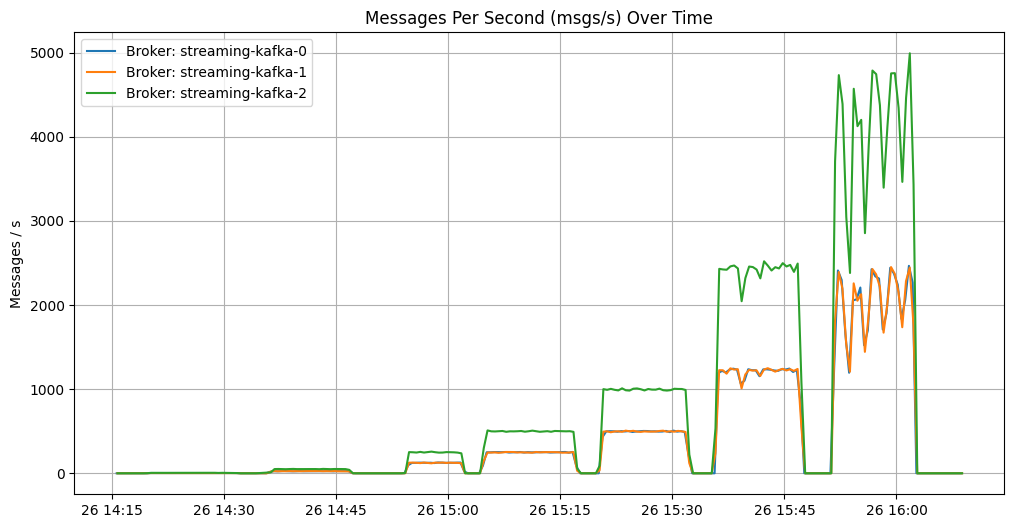

In [5]:
# 1. Analyze Messages Per Second (msgs/s)
df_msgs = load_and_prepare(files['messages'])
df_msgs = df_msgs[df_msgs["topic"] == "robot_data-avro"]
df_msgs = df_msgs.sort_values(["kubernetes_pod_name", "topic"])
if df_msgs is not None:
    df_msgs["rate"] = calculate_rate(df_msgs)

    df_msgs = df_msgs.dropna(subset=['rate'])
    
    plt.figure(figsize=(12, 6))
    for pod, data in df_msgs.groupby('kubernetes_pod_name'):
        plt.plot(data.index, data['rate'], label=f"Broker: {pod}")
    plt.title("Messages Per Second (msgs/s) Over Time")
    plt.ylabel("Messages / s")
    plt.legend()
    plt.grid(True)
    plt.savefig('rate.png')

/tmp/ipykernel_96491/4015583544.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols, group_keys=False).apply(get_rate)
/tmp/ipykernel_96491/4015583544.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols, group_keys=False).apply(get_rate)


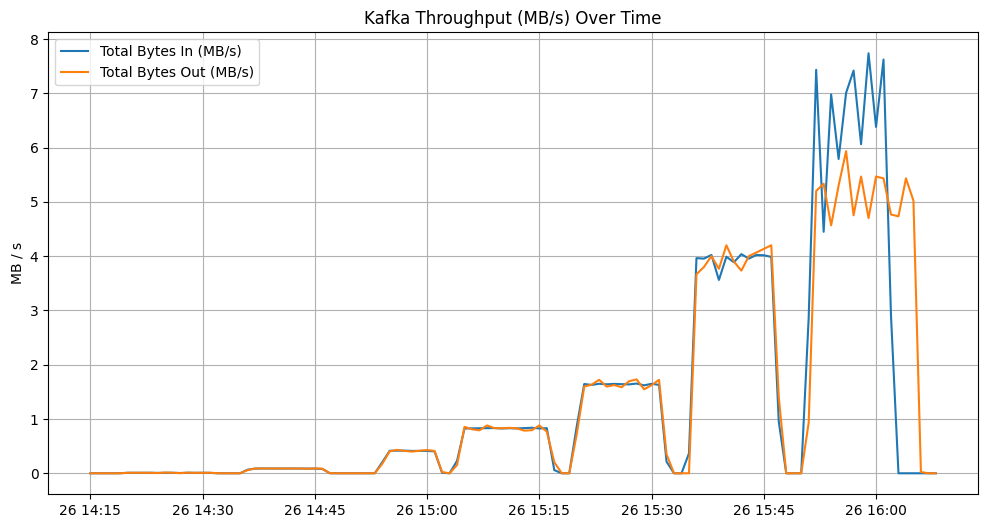

In [6]:
# 2. Analyze Bytes In and Out Over Time
df_bin = load_and_prepare(files['bytes_in'])
df_bin = df_bin[df_bin["topic"] == "robot_data-avro"]
df_bin = df_bin.sort_values(["kubernetes_pod_name", "topic"])
df_bout = load_and_prepare(files['bytes_out'])
df_bout = df_bout[df_bout["topic"] == "robot_data-avro"]
df_bout = df_bout.sort_values(["kubernetes_pod_name", "topic"])

if df_bin is not None and df_bout is not None:
    df_bin['bytes_in_per_sec'] = calculate_rate(df_bin)
    df_bout['bytes_out_per_sec'] = calculate_rate(df_bout)
    
    plt.figure(figsize=(12, 6))
    total_in = df_bin.resample('1Min')['bytes_in_per_sec'].sum()
    total_out = df_bout.resample('1Min')['bytes_out_per_sec'].sum()
    
    plt.plot(total_in.index, total_in / 1024**2, label="Total Bytes In (MB/s)")
    plt.plot(total_out.index, total_out / 1024**2, label="Total Bytes Out (MB/s)")
    plt.title("Kafka Throughput (MB/s) Over Time")
    plt.ylabel("MB / s")
    plt.legend()
    plt.grid(True)
    plt.savefig('throughput.png')

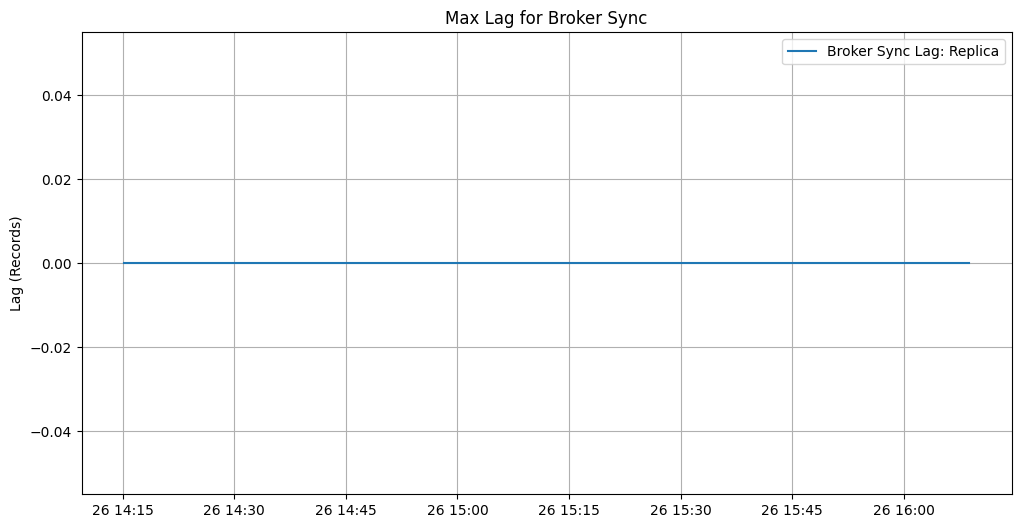

In [8]:
# 3. Analyze Lag for Broker Sync
df_lag = load_and_prepare(files['lag'], columns=["kubernetes_pod_name", "value", "clientId"])

if df_lag is not None:
    plt.figure(figsize=(12, 6))
    for client, data in df_lag.groupby('clientId'):
        plt.plot(data.index, data['value'], label=f"Broker Sync Lag: {client}")
    plt.title("Max Lag for Broker Sync")
    plt.ylabel("Lag (Records)")
    plt.legend()
    plt.grid(True)
    plt.savefig('broker_lag.png')

Analysis complete. Check the saved .png files for visualizations.


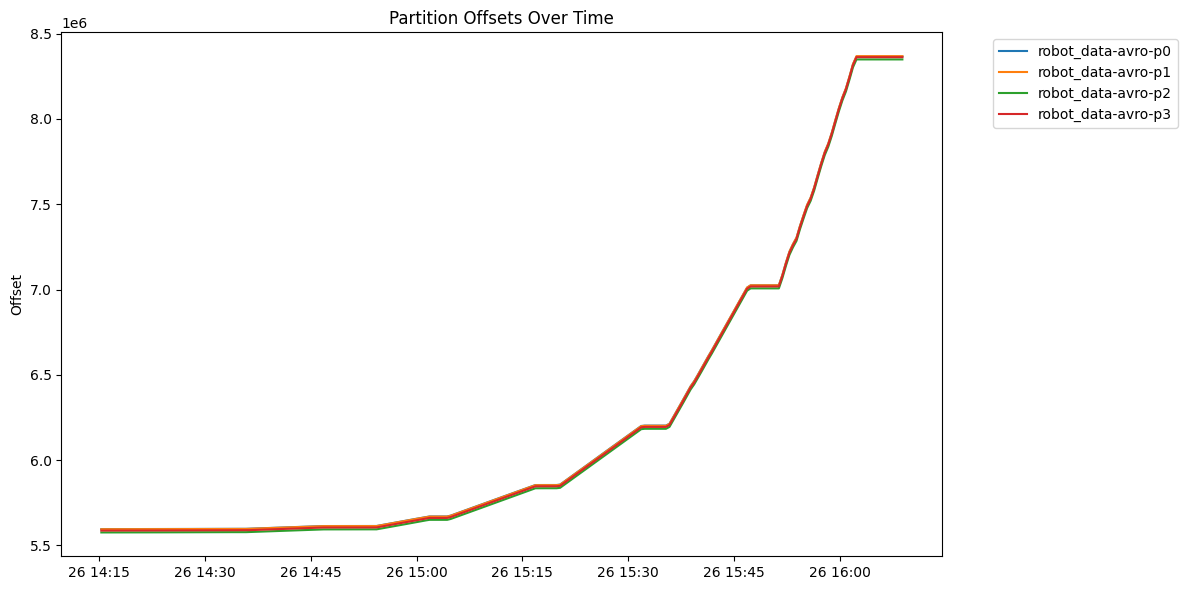

In [11]:
# 4. Offsets of Partitions Over Time
df_offsets = load_and_prepare(files['offsets'], columns=["value", "partition", "topic"])
df_offsets = df_offsets[df_offsets["topic"] == "robot_data-avro"]
if df_offsets is not None:
    plt.figure(figsize=(12, 6))
    # Plotting for a few specific partitions to avoid clutter
    for (topic, partition), data in df_offsets.groupby(['topic', 'partition']):
        plt.plot(data.index, data['value'], label=f"{topic}-p{partition}")
    plt.title("Partition Offsets Over Time")
    plt.ylabel("Offset")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('partition_offsets.png')

print("Analysis complete. Check the saved .png files for visualizations.")

--- Analyzing offsets around 2025-12-26 14:36:16 ---
Topic: robot_data-avro, Partition: 0 - No truncation detected.
Topic: robot_data-avro, Partition: 1 - No truncation detected.
Topic: robot_data-avro, Partition: 2 - No truncation detected.
Topic: robot_data-avro, Partition: 3 - No truncation detected.


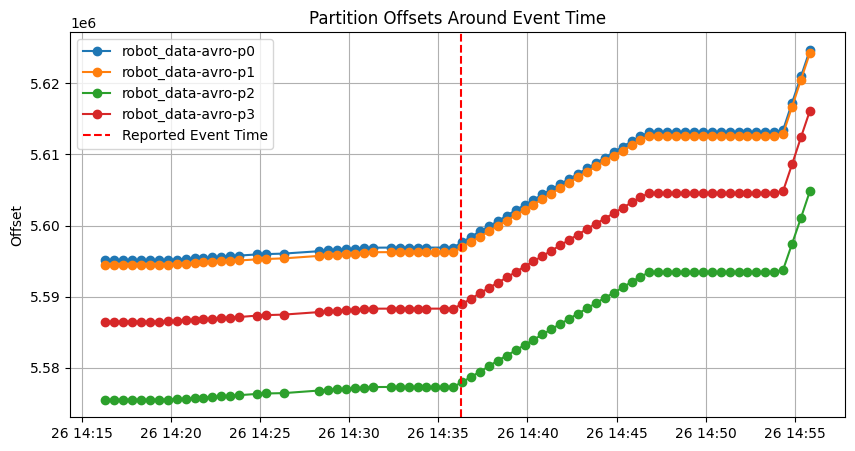

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the window around the event
target_time = pd.Timestamp('2025-12-26 14:36:16') # Edge Event
# target_time = pd.Timestamp('2025-12-26 14:20:20') # Cloud Broker Restart Event
start_window = target_time - pd.Timedelta(minutes=20)
end_window = target_time + pd.Timedelta(minutes=20)

# Filter for the window
window_data = df_offsets[
    (df_offsets.index >= start_window) & 
    (df_offsets.index <= end_window)
]

print(f"--- Analyzing offsets around {target_time} ---")

# Check for "Backward Jumps"
for (topic, partition), group in window_data.groupby(['topic', 'partition']):
    # Calculate the change in offset between consecutive samples
    group = group.copy()
    group['offset_delta'] = group['value'].diff()
    
    # Find rows where the offset decreased
    drops = group[group['offset_delta'] < 0]
    
    if not drops.empty:
        print(f"TRUNCATION DETECTED in Topic: {topic}, Partition: {partition}")
        for idx, row in drops.iterrows():
            prev_val = group.loc[:idx].iloc[-2]['value'] # The value just before the drop
            print(f"  - Time: {row.index}")
            print(f"  - Offset dropped from {prev_val} to {row['value']} (Lost {int(prev_val - row['value'])} offsets)")
    else:
        print(f"Topic: {topic}, Partition: {partition} - No truncation detected.")

# Optional: Visualize the jump
plt.figure(figsize=(10, 5))
for (topic, partition), group in window_data.groupby(['topic', 'partition']):
    plt.plot(group.index, group['value'], marker='o', label=f"{topic}-p{partition}")

plt.axvline(target_time, color='red', linestyle='--', label='Reported Event Time')
plt.title("Partition Offsets Around Event Time")
plt.ylabel("Offset")
plt.legend()
plt.grid(True)
plt.show()

# CLOUD

In [13]:
data_folder = "../../data/raw/experiment08/experiment08_cloud"

# List of files to analyze
files = {
    'messages': f'{data_folder}/kafka_server_brokertopicmetrics_messagesin_total.parquet',
    'bytes_in': f'{data_folder}/kafka_server_brokertopicmetrics_bytesin_total.parquet',
    'bytes_out': f'{data_folder}/kafka_server_brokertopicmetrics_bytesout_total.parquet',
    'lag': f'{data_folder}/kafka_server_replicafetchermanager_maxlag.parquet',
    'offsets': f'{data_folder}/kafka_topic_partition_current_offset.parquet',
    'io_ratio': f'{data_folder}/kafka_server_socket_server_metrics_io_ratio.parquet',
    'io_time': f'{data_folder}/kafka_server_socket_server_metrics_iotime.parquet'
}

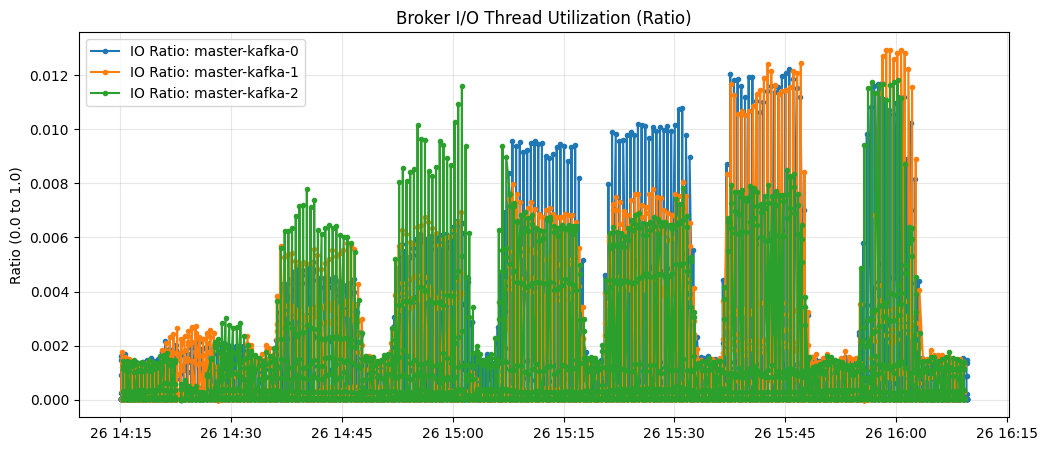

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Analyze IO Ratio (Busy-ness)
df_ratio = load_and_prepare(files['io_ratio'], columns=["kubernetes_pod_name", "value"])

plt.figure(figsize=(12, 5))
for pod, data in df_ratio.groupby('kubernetes_pod_name'):
    plt.plot(data.index, data['value'], label=f"IO Ratio: {pod}", marker='.')

plt.title("Broker I/O Thread Utilization (Ratio)")
plt.ylabel("Ratio (0.0 to 1.0)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('io_ratio_analysis.png')

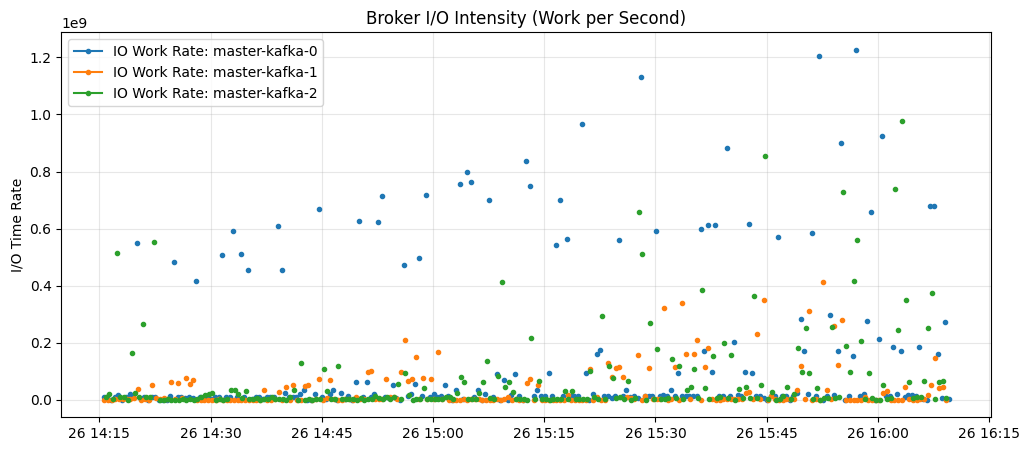

In [15]:
# 2. Analyze IO Time Rate
# IOTime is likely a counter, so we calculate the rate of change
df_iotime = load_and_prepare(files['io_time'], columns=["kubernetes_pod_name", "value"])

def calculate_io_rate(group):
    delta_val = group['value'].diff()
    delta_time = group.index.to_series().diff().dt.total_seconds()
    # Handle resets (negative delta)
    rate = delta_val / delta_time
    rate[delta_val < 0] = group['value'] / delta_time
    return rate

plt.figure(figsize=(12, 5))
for pod, data in df_iotime.groupby('kubernetes_pod_name'):
    # Ensure data is sorted for rate calculation
    data = data.sort_index()
    io_rate = calculate_io_rate(data)
    plt.plot(data.index, io_rate, label=f"IO Work Rate: {pod}", marker='.')

# plt.axvline(target_time_local, color='red', linestyle='--', label='Broker Restart')
plt.title("Broker I/O Intensity (Work per Second)")
plt.ylabel("I/O Time Rate")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('io_intensity_analysis.png')

/tmp/ipykernel_96491/4015583544.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols, group_keys=False).apply(get_rate)


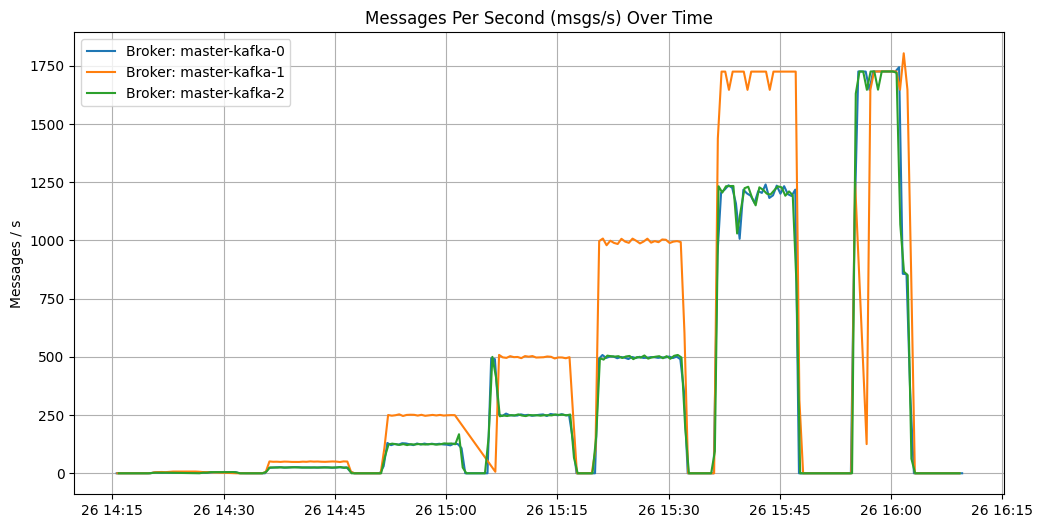

In [16]:
# 1. Analyze Messages Per Second (msgs/s)
df_msgs = load_and_prepare(files['messages'])
df_msgs = df_msgs[df_msgs["topic"] == "robot_data-avro"]
df_msgs = df_msgs.sort_values(["kubernetes_pod_name", "topic"])
if df_msgs is not None:
    df_msgs["rate"] = calculate_rate(df_msgs)

    df_msgs = df_msgs.dropna(subset=['rate'])
    
    plt.figure(figsize=(12, 6))
    for pod, data in df_msgs.groupby('kubernetes_pod_name'):
        plt.plot(data.index, data['rate'], label=f"Broker: {pod}")
    plt.title("Messages Per Second (msgs/s) Over Time")
    plt.ylabel("Messages / s")
    plt.legend()
    plt.grid(True)
    plt.savefig('rate.png')

/tmp/ipykernel_96491/4015583544.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols, group_keys=False).apply(get_rate)
/tmp/ipykernel_96491/4015583544.py:36: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols, group_keys=False).apply(get_rate)


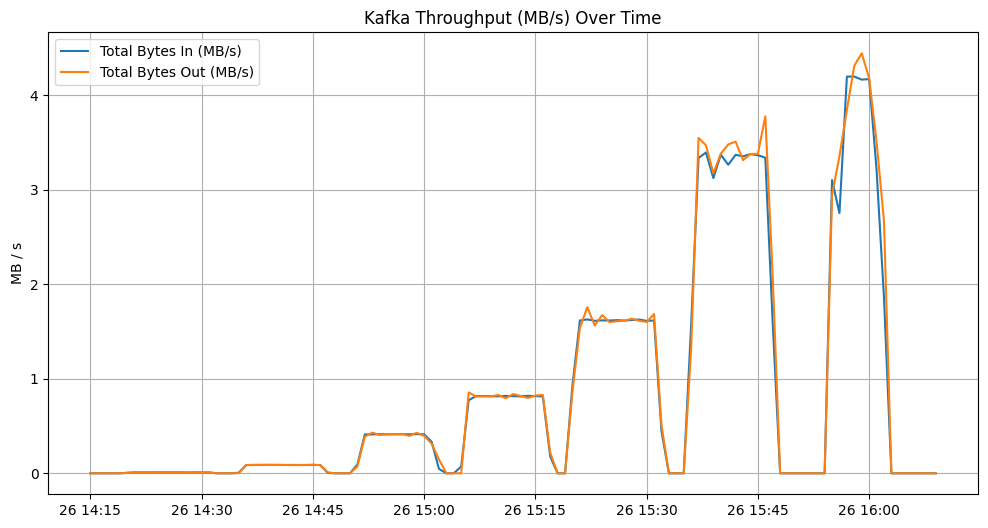

In [17]:
# 2. Analyze Bytes In and Out Over Time
df_bin = load_and_prepare(files['bytes_in'])
df_bin = df_bin[df_bin["topic"] == "robot_data-avro"]
df_bin = df_bin.sort_values(["kubernetes_pod_name", "topic"])
df_bout = load_and_prepare(files['bytes_out'])
df_bout = df_bout[df_bout["topic"] == "robot_data-avro"]
df_bout = df_bout.sort_values(["kubernetes_pod_name", "topic"])

if df_bin is not None and df_bout is not None:
    df_bin['bytes_in_per_sec'] = calculate_rate(df_bin)
    df_bout['bytes_out_per_sec'] = calculate_rate(df_bout)
    
    plt.figure(figsize=(12, 6))
    total_in = df_bin.resample('1Min')['bytes_in_per_sec'].sum()
    total_out = df_bout.resample('1Min')['bytes_out_per_sec'].sum()
    
    plt.plot(total_in.index, total_in / 1024**2, label="Total Bytes In (MB/s)")
    plt.plot(total_out.index, total_out / 1024**2, label="Total Bytes Out (MB/s)")
    plt.title("Kafka Throughput (MB/s) Over Time")
    plt.ylabel("MB / s")
    plt.legend()
    plt.grid(True)
    plt.savefig('throughput.png')

In [18]:
pd.read_parquet(f'{data_folder}/kafka_server_replicafetchermanager_maxlag.parquet')

,__name__,app_kubernetes_io_instance,app_kubernetes_io_managed_by,app_kubernetes_io_name,app_kubernetes_io_part_of,argocd_argoproj_io_instance,clientId,container,endpoint,instance,...,strimzi_io_cluster,strimzi_io_component_type,strimzi_io_controller,strimzi_io_controller_name,strimzi_io_controller_role,strimzi_io_kind,strimzi_io_name,strimzi_io_pod_name,strimzi_io_pool_name,value
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-12-26 16:40:06.415999889,kafka_server_replicafetchermanager_maxlag,master,strimzi-cluster-operator,kafka,strimzi-master,kafka-broker,Replica,kafka,tcp-prometheus,10.244.0.14:9404,...,master,kafka,strimzipodset,master-kafka,false,Kafka,master-kafka,master-kafka-1,kafka,0.0
2025-12-26 16:40:36.415999889,kafka_server_replicafetchermanager_maxlag,master,strimzi-cluster-operator,kafka,strimzi-master,kafka-broker,Replica,kafka,tcp-prometheus,10.244.0.14:9404,...,master,kafka,strimzipodset,master-kafka,false,Kafka,master-kafka,master-kafka-1,kafka,0.0
2025-12-26 16:41:06.415999889,kafka_server_replicafetchermanager_maxlag,master,strimzi-cluster-operator,kafka,strimzi-master,kafka-broker,Replica,kafka,tcp-prometheus,10.244.0.14:9404,...,master,kafka,strimzipodset,master-kafka,false,Kafka,master-kafka,master-kafka-1,kafka,0.0
2025-12-26 16:41:36.415999889,kafka_server_replicafetchermanager_maxlag,master,strimzi-cluster-operator,kafka,strimzi-master,kafka-broker,Replica,kafka,tcp-prometheus,10.244.0.14:9404,...,master,kafka,strimzipodset,master-kafka,false,Kafka,master-kafka,master-kafka-1,kafka,0.0
2025-12-26 16:42:06.415999889,kafka_server_replicafetchermanager_maxlag,master,strimzi-cluster-operator,kafka,strimzi-master,kafka-broker,Replica,kafka,tcp-prometheus,10.244.0.14:9404,...,master,kafka,strimzipodset,master-kafka,false,Kafka,master-kafka,master-kafka-1,kafka,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-26 19:07:14.203999996,kafka_server_replicafetchermanager_maxlag,master,strimzi-cluster-operator,kafka,strimzi-master,kafka-broker,Replica,kafka,tcp-prometheus,10.244.1.27:9404,...,master,kafka,strimzipodset,master-kafka,false,Kafka,master-kafka,master-kafka-2,kafka,0.0
2025-12-26 19:07:44.203999996,kafka_server_replicafetchermanager_maxlag,master,strimzi-cluster-operator,kafka,strimzi-master,kafka-broker,Replica,kafka,tcp-prometheus,10.244.1.27:9404,...,master,kafka,strimzipodset,master-kafka,false,Kafka,master-kafka,master-kafka-2,kafka,0.0
2025-12-26 19:08:14.203999996,kafka_server_replicafetchermanager_maxlag,master,strimzi-cluster-operator,kafka,strimzi-master,kafka-broker,Replica,kafka,tcp-prometheus,10.244.1.27:9404,...,master,kafka,strimzipodset,master-kafka,false,Kafka,master-kafka,master-kafka-2,kafka,0.0


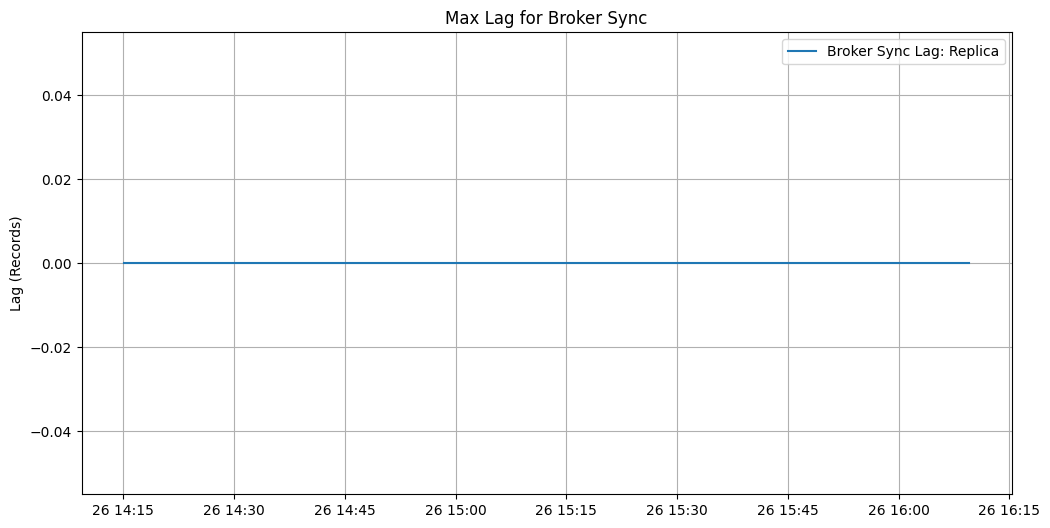

In [19]:
# 3. Analyze Lag for Broker Sync
df_lag = load_and_prepare(files['lag'], columns=["kubernetes_pod_name", "value", "clientId"])

if df_lag is not None:
    plt.figure(figsize=(12, 6))
    for client, data in df_lag.groupby('clientId'):
        plt.plot(data.index, data['value'], label=f"Broker Sync Lag: {client}")
    plt.title("Max Lag for Broker Sync")
    plt.ylabel("Lag (Records)")
    plt.legend()
    plt.grid(True)
    plt.savefig('broker_lag.png')

Analysis complete. Check the saved .png files for visualizations.


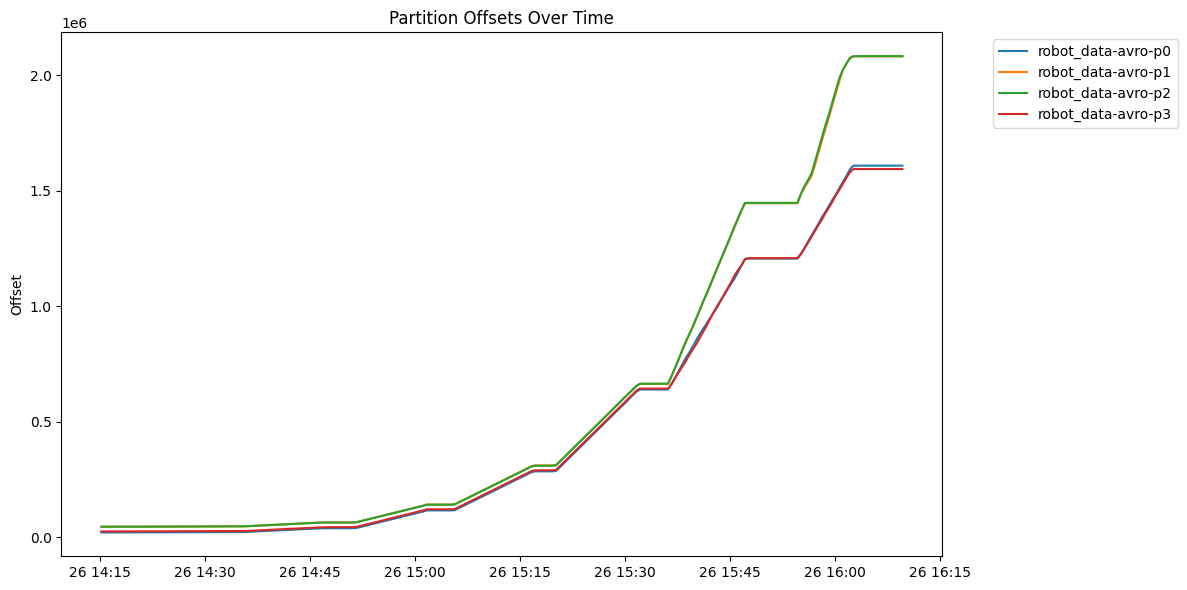

In [20]:
# 4. Offsets of Partitions Over Time
df_offsets = load_and_prepare(files['offsets'], columns=["value", "partition", "topic", "kubernetes_pod_name"])
df_offsets = df_offsets[df_offsets["topic"] == "robot_data-avro"]
if df_offsets is not None:
    plt.figure(figsize=(12, 6))
    # Plotting for a few specific partitions to avoid clutter
    for (topic, partition), data in df_offsets.groupby(['topic', 'partition']):
        plt.plot(data.index, data['value'], label=f"{topic}-p{partition}")
    plt.title("Partition Offsets Over Time")
    plt.ylabel("Offset")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('partition_offsets.png')

print("Analysis complete. Check the saved .png files for visualizations.")

--- Analyzing offsets around 2025-12-26 14:20:20 ---
Topic: robot_data-avro, Partition: 0 - No truncation detected.
Topic: robot_data-avro, Partition: 1 - No truncation detected.
Topic: robot_data-avro, Partition: 2 - No truncation detected.
Topic: robot_data-avro, Partition: 3 - No truncation detected.


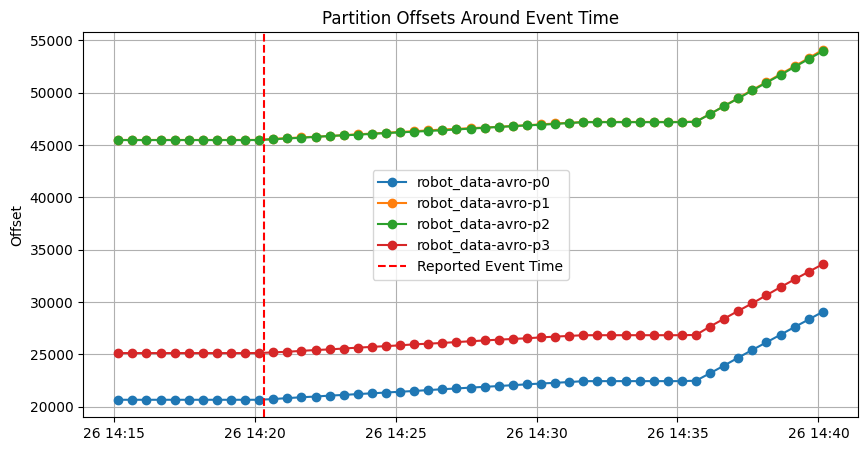

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the window around the event
# target_time = pd.Timestamp('2025-12-26 14:36:16') # Edge Event
target_time = pd.Timestamp('2025-12-26 14:20:20') # Cloud Broker Restart Event
start_window = target_time - pd.Timedelta(minutes=20)
end_window = target_time + pd.Timedelta(minutes=20)

# Filter for the window
window_data = df_offsets[
    (df_offsets.index >= start_window) & 
    (df_offsets.index <= end_window)
]

print(f"--- Analyzing offsets around {target_time} ---")

# Check for "Backward Jumps"
for (topic, partition), group in window_data.groupby(['topic', 'partition']):
    # Calculate the change in offset between consecutive samples
    group = group.copy()
    group['offset_delta'] = group['value'].diff()
    
    # Find rows where the offset decreased
    drops = group[group['offset_delta'] < 0]
    
    if not drops.empty:
        print(f"TRUNCATION DETECTED in Topic: {topic}, Partition: {partition}")
        for idx, row in drops.iterrows():
            prev_val = group.loc[:idx].iloc[-2]['value'] # The value just before the drop
            print(f"  - Time: {row.index}")
            print(f"  - Offset dropped from {prev_val} to {row['value']} (Lost {int(prev_val - row['value'])} offsets)")
    else:
        print(f"Topic: {topic}, Partition: {partition} - No truncation detected.")

# Optional: Visualize the jump
plt.figure(figsize=(10, 5))
for (topic, partition), group in window_data.groupby(['topic', 'partition']):
    plt.plot(group.index, group['value'], marker='o', label=f"{topic}-p{partition}")

plt.axvline(target_time, color='red', linestyle='--', label='Reported Event Time')
plt.title("Partition Offsets Around Event Time")
plt.ylabel("Offset")
plt.legend()
plt.grid(True)
plt.show()